In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset
from experiment import Experiment
from MDP_helpers import calculate_gap

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score


from time import time
from tqdm import tqdm
import gc

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device='cpu'
print(device)

cpu


In [4]:
N_datasets = 100

N_sites = 6
N_species = 20
K = 9

N_states = 3**N_sites

generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=False)#, folder="hparam_data")

'Data already exists'

In [5]:
dataset = InMemoryMDPDataset(f"datasets/mdp_{N_states}_state", pre_transform=AllNodeFeatures())

In [6]:
hparams = Experiment('best_params').load()
hparams = pd.DataFrame(hparams).sort_values(by='score', ascending=True)

In [7]:
best_params = hparams.loc[0]
hparams[hparams['lr']>0][0:30]

,score,hidden_channels,num_layers,dropout,lr,weight_decay,gamma
13,0.300534,176.0,1.0,0.004101,2.698927,0.001483,0.997018
23,0.300578,181.0,1.0,0.011083,1.437395,0.001152,0.993384
21,0.330314,200.0,1.0,0.010138,1.470617,0.012731,0.995448
19,0.335703,199.0,1.0,0.023975,2.237262,0.001150,0.969591
16,0.341265,198.0,1.0,0.000221,0.233100,0.022892,0.994612
28,0.342057,149.0,1.0,0.007412,0.905140,0.020630,0.996630
14,0.394558,124.0,1.0,0.004573,1.926734,0.042765,0.984233
29,0.933195,184.0,1.0,0.016503,2.584442,0.013937,0.915158
22,1.006778,200.0,1.0,0.026455,2.012364,0.011800,0.923395
24,1.062955,178.0,1.0,0.010932,1.298478,0.013479,0.888989


In [8]:
# best_params

In [9]:
# best_params = {'score': 0.300534,
#  'hidden_channels': 176.0,
#  'num_layers': 1.0,
#  'dropout': 0.004101,
#  'lr': 2.698927,
#  'weight_decay': 0.001483,
#  'gamma': 0.997018}

# best_params = {'hidden_channels': 242, 'num_layers': 1, 'dropout': 0.006388262917827664, 'lr': 2.526232386830896, 'weight_decay': 0.030035363538740922, 'gamma': 0.9342259989713417}

In [10]:
# best_params = {'score': 0.3005344048681545,
#  'hidden_channels': 176.0,
#  'num_layers': 1.0,
#  'dropout': 0.004100687104164412,
#  'lr': 2.698927286009522,
#  'weight_decay': 0.0014830234258634764,
#  'gamma': 0.9970183847892857}

In [11]:
# best_params['gamma'] = 1 - 0.1
# best_params['lr'] = 2

In [12]:
best_params

score                1.617770
hidden_channels    175.000000
num_layers           1.000000
dropout              0.075466
lr                   6.075250
weight_decay         0.011337
gamma                0.442118
Name: 0, dtype: float64

In [13]:
all_results = defaultdict(lambda : defaultdict(list))
N_epochs = 200

times = defaultdict(float)

for trial_num in range(10):
    trial_name = f"trial_{trial_num}"
    torch.cuda.manual_seed(trial_num)

    #-------------------------------------------------------------------------------------------------------------------#
    train_ratio = 0.8
    test_ratio = 0.2

    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_data = DataLoader(train_set, batch_size=1, shuffle=True)
    test_data = DataLoader(test_set, batch_size=1, shuffle=True)

    #-------------------------------------------------------------------------------------------------------------------#
    gcn_model = GCN(
        in_channels=int(dataset[0].x.shape[1]), 
        out_channels=K, 
        hidden_channels=int(best_params['hidden_channels']), 
        num_layers=int(best_params['num_layers']), 
        dropout=best_params['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(gcn_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])


    loss_function = torch.nn.CrossEntropyLoss()
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=best_params['gamma'])

    #-------------------------------------------------------------------------------------------------------------------#
    epochs = tqdm(range(N_epochs))
    training_time = 0
    for epoch in epochs:
        t1 = time()
        gcn_model.train()
        optimizer.zero_grad()

        total_loss = 0
        for data in train_data:
            pred = gcn_model(
                x = data.x.to(device),
                edge_index = data.edges.to(device)
            )
            total_loss += loss_function(pred, data.k_labels.to(device))
        
        total_loss /= len(train_data)
        total_loss.backward()
        optimizer.step()
        lr_sheduler.step()

        training_time += time() - t1

        all_results[trial_name]['training_loss'].append(total_loss.to('cpu').detach().float())

        gcn_model.eval()
        total_gap = 0
        total_error = 0
        total_recall = 0
        test_loss = 0
        for data in test_data:
            pred = gcn_model(
                x = data.x.to(device),
                edge_index = data.edges.to(device)
            )

            test_loss += loss_function(pred, data.k_labels.to(device))

            pred_k = F.softmax(pred, dim=1).argmax(axis=1)
            gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
            total_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")
            total_gap += gap
            total_error += error


        total_gap /= len(train_data)
        total_error/=len(test_data)
        total_recall/=len(test_data)
        test_loss /= len(test_data)

    
        all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
        all_results[trial_name]['testing_gap'].append(total_gap.to('cpu').detach().float())
        all_results[trial_name]['testing_error'].append(total_error.to('cpu').detach().float())
        all_results[trial_name]['test_recall'].append(total_recall)

        epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {total_loss:.4f}, Gap {total_gap:.4f}, Recall {total_recall:.4f}")
    #-------------------------------------------------------------------------------------------------------------------#
    times[trial_name] = training_time

  0%|          | 0/200 [00:00<?, ?it/s]

/home/james/Repo/MDP-State-Abstraction-CSIRO/gcn_model_multi/MDP_helpers.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
Trial 0, Epoch 21/200, Loss 3.7102, Gap 0.0618, Recall 0.0591:  10%|█         | 21/200 [00:39<05:39,  1.89s/it]


KeyboardInterrupt: 

In [ ]:
os.mkdir(f"multi_run_{N_states}_states_10_runs")

times = pd.Series(times)
times.to_csv(f"multi_run_{N_states}_states_10_runs/times.csv")

training_loss = pd.DataFrame({trial_id:all_results[trial_id]['training_loss'] for trial_id in all_results.keys()}).astype(float)
test_loss = pd.DataFrame({trial_id:all_results[trial_id]['test_loss'] for trial_id in all_results.keys()}).astype(float)
test_gap = pd.DataFrame({trial_id:all_results[trial_id]['testing_gap'] for trial_id in all_results.keys()}).astype(float)
test_error = pd.DataFrame({trial_id:all_results[trial_id]['testing_error'] for trial_id in all_results.keys()}).astype(float)

training_loss.to_csv(f"multi_run_{N_states}_states_10_runs/training_loss.csv")
test_loss.to_csv(f"multi_run_{N_states}_states_10_runs/test_loss.csv")
test_gap.to_csv(f"multi_run_{N_states}_states_10_runs/test_gap.csv")
test_error.to_csv(f"multi_run_{N_states}_states_10_runs/test_error.csv")

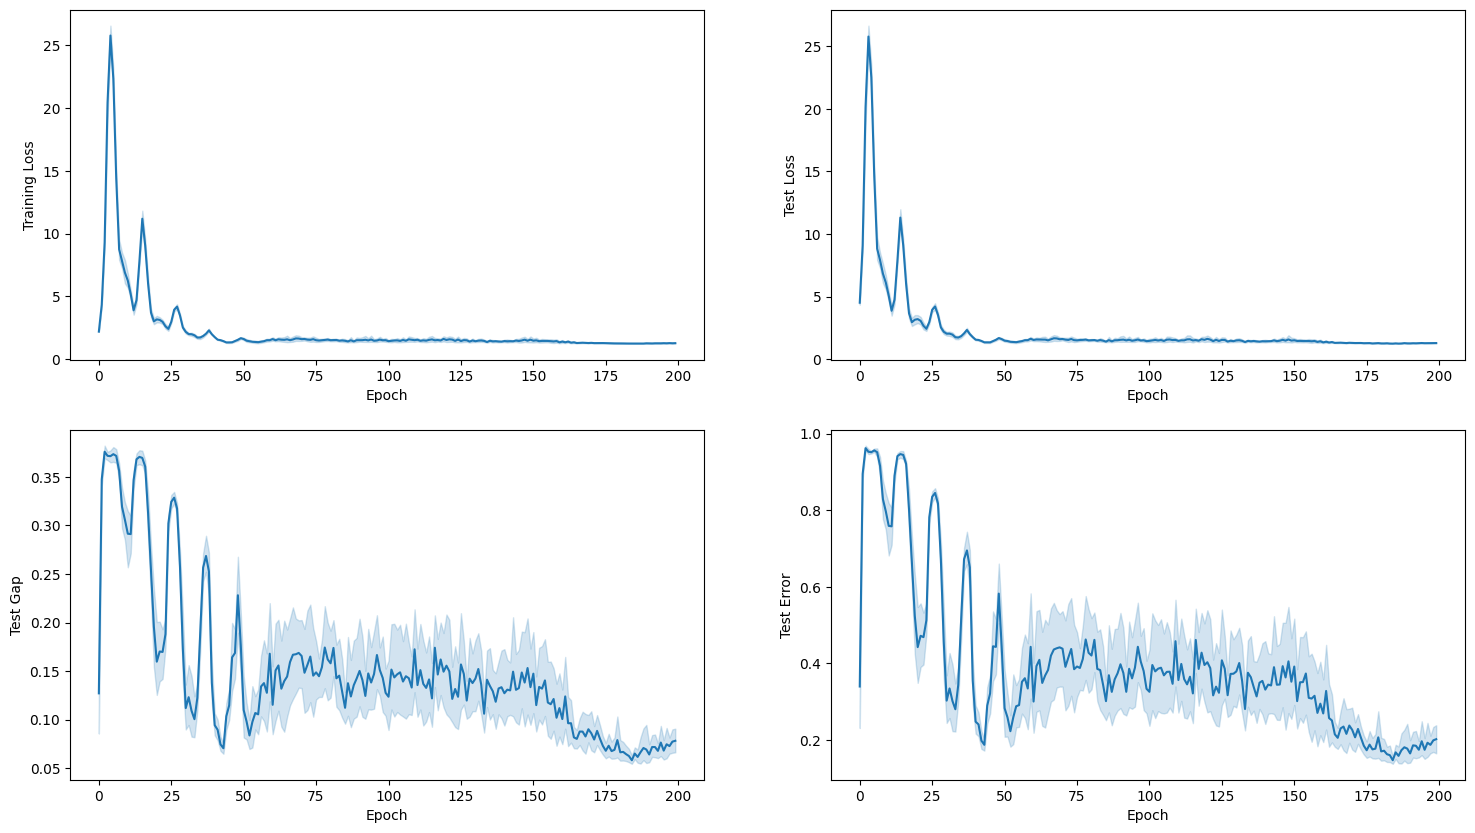

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))

training_loss_long = training_loss.stack()
training_loss_long.index = training_loss_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(training_loss_long, errorbar='ci', ax=ax[0, 0])
ax[0, 0].set_ylabel("Training Loss")
ax[0, 0].set_xlabel("Epoch")

test_loss_long = test_loss.stack()
test_loss_long.index = test_loss_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_loss_long, errorbar='ci', ax=ax[0, 1])
ax[0, 1].set_ylabel("Test Loss")
ax[0, 1].set_xlabel("Epoch")


test_gap_long = test_gap.stack()
test_gap_long.index = test_gap_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_gap_long, errorbar='ci', ax=ax[1, 0])
ax[1, 0].set_ylabel("Test Gap")
ax[1, 0].set_xlabel("Epoch")

# ax[1, 0].hlines(np.mean(true_gap), 0, 300)

test_error_long = test_error.stack()
test_error_long.index = test_error_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_error_long, errorbar='ci', ax=ax[1, 1])
ax[1, 1].set_ylabel("Test Error")
ax[1, 1].set_xlabel("Epoch")
# ax[1, 1].hlines(np.mean(true_error), 0, 300)

plt.savefig(f"multi_run_{N_states}_states_10_runs/results.png")